In [1]:
# %load notebook_setup.py
#Use %load notebook_setup.py to load these commands at the top of your
#ipython notebook.  Includes running the std_libraries.py file. 

%run std_libraries.py
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
%matplotlib inline
#%matplotlib notebook

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = otherb
home directory is /home/heineike/
y1000plus_tools dir is /home/heineike/github/y1000plus_tools/
y1000plus data dir is /home/heineike/genomes/y1000plus/
Added /home/heineike/github/y1000plus_tools/ to path
Added /home/heineike/github/yeast_esr_expression_analysis/ to path
Importing y1000plus_tools.py
home directory is unset
y1000plus_tools dir is unset
y1000plus data dir is unset
Importing yeast_esr_exp.  If autoreload, may need to reset base_dir and data_processing dir 
  yeast_esr_exp.base_dir=base_dir 
 yeast_esr_exp.data_processing_dir = data_processing_dir
sys.path : 

['/home/heineike/github/y1000plus_tools/scripts', '', '/home/lab/envs/seqanalysis/lib/python35.zip', '/home/lab/envs/seqanalysis/lib/python3.5', '/home/lab/envs/seqanalysis/lib/python3.5/plat-linux', '/home/lab/envs/seqanalysis/lib/python3.5/lib-dynload', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages', '/home/lab/envs/

In [ ]:
#Converts the Lys14 pwm from meme to a counts file for Jaspar so I can load it into biopython
#Only need to do this once


# lys14_pwm = """0.588235 0.058824 0.039216 0.313725
# 0.509804 0.019608 0.058824 0.411765
# 0.372549 0.000000 0.098039 0.529412
# 0.058824 0.000000 0.000000 0.941176
# 0.000000 0.137255 0.019608 0.843137
# 0.019608 0.980392 0.000000 0.000000
# 0.000000 1.000000 0.000000 0.000000
# 0.588235 0.215686 0.176471 0.019608
# 0.156863 0.431373 0.352941 0.058824
# 0.156863 0.647059 0.000000 0.196078
# 0.000000 0.000000 0.941176 0.058824
# 0.000000 0.156863 0.843137 0.000000
# 0.843137 0.000000 0.098039 0.058824
# 0.980392 0.000000 0.000000 0.019608
# 0.019608 0.000000 0.019608 0.960784
# 0.137255 0.019608 0.000000 0.843137
# 0.078431 0.117647 0.039216 0.764706
# 0.098039 0.411765 0.196078 0.294118"""

# rows = []
# for row in lys14_pwm.split('\n'):
#     row_clean = [float(item) for item in row.split()]
#     rows.append(row_clean)



# #the number 

# N_scale = 51 #The scaling factor was obtained by dividing 1 by the smallest nonzero number in the pwm

# count_matrix = np.round((np.array(rows)*N_scale)).T

# fname_lys_jaspar = home_dir + 'github/yeast_esr_expression_analysis/expression_data/motifs/Lys14_intergenics_20190415.jaspar'

# base_order = 'ACGT'
# with open(fname_lys_jaspar,'w') as f:
#     f.write('>Lys14_intergenics_20190415\tLYS14\n')
#     for jj, counts in enumerate(count_matrix):
#         f.write(base_order[jj] + '  [ ')
#         for item in counts: 
#             f.write(str(int(item)) + ' ')
#         f.write(' ]\n')

# Load Data

In [2]:
#set up data matrix based on time-calibrated species tree, and take subset of species based on species subset
tree_fname = y1000plus_dir + '332_2408OGs_time-calibrated_phylogeny_species-names_updated.newick'
t = Tree(tree_fname)
t.ladderize()

332

In [5]:
#Gets subset of species to focus on

ca_cousins = t.get_common_ancestor(['Candida_albicans', 'Spathaspora_gorwiae']).get_leaves()
ca_cousins_names = [node.name for node in ca_cousins]
ca_cousins_color = "#f9e284"

sc_cousins = t.get_common_ancestor(['Saccharomyces_eubayanus', 'Candida_glabrata']).get_leaves()    #'Vanderwaltozyma_polyspora'
sc_cousins_names = [node.name for node in sc_cousins]
sc_cousins_color = "#aad1ef"

In [3]:
#Load species subset - either smaller subset, or all species

#Currently loading all species

##Load all species and take subset that has genomes
y1000_species = pd.read_csv(y1000plus_dir + "y1000_species_table.csv", index_col=0)

#not including outgroup species
y1000_species_subset = y1000_species[y1000_species['Major clade']!='outgroup']

# #Species subset is only the Calb and Scer cousins
# y1000_species_subset = y1000_species[y1000_species['species_names_fig2'].isin(ca_cousins_names+sc_cousins_names)]


#Lookup table for og id number
spec_og_id_lookup = dict(zip(y1000_species_subset['original_genome_id'], y1000_species_subset['spec_og_id']))


In [ ]:
# #Load y1000plus species table, make species_subset table 

# specs_fig2 = [ 'Saccharomyces_cerevisiae', 'Kluyveromyces_lactis', 'Hanseniaspora_uvarum','Hanseniaspora_vineae' ,'Wickerhamomyces_anomalus', 'Candida_albicans']

# y1000_species = pd.read_csv(y1000plus_dir + "y1000_species_table.csv", index_col=0)

# fig2_to_orig = dict(zip(y1000_species['species_names_fig2'], y1000_species['original_genome_id']))

# y1000_species_subset = y1000_species[y1000_species['species_names_fig2'].isin(specs_fig2)]



In [5]:
#Load AA metabolism genes, make goi_og_lookup
aa_met_genes = pd.read_csv(base_dir + os.path.normpath('data/gcn4_liron/aa_metabolism_genes.csv'), index_col=0)

gois = list(aa_met_genes.index)

#Make promoter files for various genes of interest
#Load S.Cer lookup table: 
scer_lookup_fname = y1000plus_dir + os.path.normpath('id_lookups/saccharomyces_cerevisiae.csv')

scer_lookup = pd.read_csv(scer_lookup_fname, index_col=0)
scer_lookup['SC_common_name'] = y1000plus_tools.yeast_esr_exp.SC_common_name_lookup(scer_lookup.index)

y1000_id_lookup_common = dict(zip(scer_lookup['SC_common_name'], scer_lookup['y1000_id']))
sc_genename_lookup_common = dict(zip(scer_lookup['SC_common_name'],scer_lookup.index))

# target_y1000_id = scer_lookup.loc[goi,'y1000_id']

y1000_ids = dict(scer_lookup.loc[gois,'y1000_id'])
y1000_id_list = [y1000_ids[goi] for goi in gois]

goi_og_lookup, og_genes_lookup = y1000plus_tools.make_og_genes_lookup(y1000_id_list, y1000_species_subset)

more than one goi in same orthogroup :OG1030 found_genes: 
['110_4697', '110_4199']
more than one goi in same orthogroup :OG1096 found_genes: 
['110_946', '110_4987']
more than one goi in same orthogroup :OG1115 found_genes: 
['110_827', '110_449']
more than one goi in same orthogroup :OG1210 found_genes: 
['110_425', '110_1406']
more than one goi in same orthogroup :OG1313 found_genes: 
['110_447', '110_3134']
more than one goi in same orthogroup :OG1433 found_genes: 
['110_634', '110_2626']
more than one goi in same orthogroup :OG1516 found_genes: 
['110_695', '110_4813']
more than one goi in same orthogroup :OG1675 found_genes: 
['110_4331', '110_1965']
more than one goi in same orthogroup :OG1892 found_genes: 
['110_2273', '110_217']
more than one goi in same orthogroup :OG2588 found_genes: 
['110_4392', '110_1713']
more than one goi in same orthogroup :OG4216 found_genes: 
['110_1130', '110_4035']


In [6]:
#make pathway list
pathway_table = pd.read_csv(base_dir + os.path.normpath('data/gcn4_liron/scer_AABGs_pathways.csv'), index_col = 0)
all_pway_names = set()
for column in ['Pathway'+str(NN) for NN in range(1,5)]:
    all_pway_names = all_pway_names | (set(pathway_table[column]))

all_pway_names = all_pway_names - {np.nan}

all_pways = {pway : [] for pway in all_pway_names}


for (genename, (common_name, pway1,pway2, pway3, pway4)) in pathway_table.iterrows():
    for pway in [pway1,pway2, pway3, pway4]:
        if isinstance(pway, str):
            all_pways[pway].append(common_name)

            
#Combine overlapping pathways
all_pways['bcaa'] = list(set(all_pways['leu'] + all_pways['ile'] + all_pways['val'] + all_pways['branched']))
all_pways['aromatic'] = list(set(all_pways['chorismate'] + all_pways['phe'] + all_pways['trp'] + all_pways['tyr']))
all_pways['cys_met_thr'] = list(set(all_pways['homoserine']+all_pways['met']+all_pways['cys']+all_pways['thr']))

all_pways_combined_keys = list(set(all_pways.keys()) - set(['leu','ile','val','branched','chorismate','phe','trp','tyr','homoserine','met','cys','thr']))

all_pways_combined = {}
for pway in all_pways_combined_keys: 
    all_pways_combined[pway] = all_pways[pway]
    all_pways_combined[pway].sort()


all_pways_combined

{'arg': ['ARG1', 'ARG2', 'ARG3', 'ARG4', 'ARG5,6', 'ARG7', 'ARG8'],
 'aromatic': ['ARO1',
  'ARO2',
  'ARO3',
  'ARO4',
  'ARO7',
  'ARO8',
  'ARO9',
  'PHA2',
  'TRP1',
  'TRP2',
  'TRP3',
  'TRP5',
  'TYR1'],
 'asn': ['ASN2'],
 'asp': ['AAT1', 'AAT2', 'PYC2'],
 'bcaa': ['BAT2',
  'ILV1',
  'ILV2',
  'ILV3',
  'ILV5',
  'ILV6',
  'LEU1',
  'LEU2',
  'LEU3',
  'LEU4'],
 'cys_met_thr': ['CBF1',
  'CYS3',
  'CYS4',
  'HOM2',
  'HOM3',
  'HOM6',
  'MET10',
  'MET14',
  'MET16',
  'MET17',
  'MET2',
  'MET3',
  'MET31',
  'MET32',
  'MET4',
  'MET5',
  'MET6',
  'MET7',
  'THR1',
  'THR4'],
 'gln': ['GLN1'],
 'glu': ['ALT1', 'GDH3', 'GLT1'],
 'gly': ['AGX1', 'GLY1'],
 'his': ['HIS1',
  'HIS2',
  'HIS3',
  'HIS4',
  'HIS5',
  'HIS6',
  'HIS7',
  'PRS1',
  'PRS3',
  'PRS4',
  'PRS5'],
 'lys': ['LYS1', 'LYS12', 'LYS14', 'LYS2', 'LYS21', 'LYS4', 'LYS5', 'LYS9'],
 'pro': ['PRO1', 'PRO2', 'PRO3'],
 'ser': ['SER1', 'SER2', 'SER3', 'SHM1', 'SHM2']}

In [7]:
y1000_species_subset

,original_genome_id,old_species_names,species_names_fig2,hex,id_table S1,Species name,Major clade,clade_order,Family,Genus,CUG usage,spec_og_id
ID,,,,,,,,,,,,
1,saprochaete_clavata,Saprochaete_clavata,Saprochaete_clavata,#FF2800,22,Saprochaete clavata,Dipodascaceae/Trichomonascaceae,3,Dipodascaceae,Saprochaete,Leu,118
2,yHMPu5000034974_deakozyma_indianensis_160519,yHMPu5000034974_Deakozyma_indianensis,Deakozyma_indianensis,#FF2800,39,Deakozyma indianensis,Dipodascaceae/Trichomonascaceae,3,Saccharomycetales incertae sedis,Deakozyma,Leu,251
3,clavispora_lusitaniae,Clavispora_lusitaniae,Clavispora_lusitaniae,#FFd200,135,Clavispora lusitaniae,CUG-Ser1,8,Metschnikowiaceae,Clavispora,Ser,32
4,yHMPu5000034999_cephaloascus_fragrans_160519,yHMPu5000034999_Cephaloascus_fragrans,Cephaloascus_fragrans,#FFd200,204,Cephaloascus fragrans,CUG-Ser1,8,Cephaloascaceae,Cephaloascus,Ser,258
5,yHMPu5000034998_cephaloascus_albidus_160519,yHMPu5000034998_Cephaloascus_albidus,Cephaloascus_albidus,#FFd200,205,Cephaloascus albidus,CUG-Ser1,8,Cephaloascaceae,Cephaloascus,Ser,257
6,babjeviella_inositovora,Babjeviella_inositovora,Babjeviella_inositovora,#FFd200,122,Babjeviella inositovora,CUG-Ser1,8,Debaryomycetaceae,Babjeviella,Ser,9
7,candida_dubliniensis,Candida_dubliniensis,Candida_dubliniensis,#FFd200,126,Candida dubliniensis,CUG-Ser1,8,Debaryomycetaceae,Candida,Ser,18
8,candida_albicans,Candida_albicans,Candida_albicans,#FFd200,123,Candida albicans,CUG-Ser1,8,Debaryomycetaceae,Candida,Ser,12
9,candida_parapsilosis,Candida_parapsilosis,Candida_parapsilosis,#FFd200,130,Candida parapsilosis,CUG-Ser1,8,Debaryomycetaceae,Candida,Ser,24


In [10]:
# Assign Genome Names

# # species_names_fig = ['Torulaspora delbrueckii', 'Zygosaccharomyces bailii', 'Zygosaccharomyces rouxii', 'Zygotorulaspora florentina', 
# #  'Metschnikowia hawaiiensis', 'Kluyveromyces lactis', 'Kluyveromyces marxianus', 'Eremothecium gossypii', 
# #  'Candida albicans', 'Debaryomyces hansenii', 'Hanseniaspora vineae', 'Cyberlindnera jadinii', 
# #  'Wickerhamomyces anomalus', 'Ascoidea rubescens','Komagataella pastoris']

# #species_names_fig = ['Kluyveromyces lactis','Candida albicans'] #['Torulaspora delbrueckii', 'Zygosaccharomyces bailii', 'Zygosaccharomyces rouxii', 'Zygotorulaspora florentina', 
#  #'Metschnikowia hawaiiensis',  'Kluyveromyces marxianus', 'Eremothecium gossypii', 'Hanseniaspora vineae', 'Cyberlindnera jadinii', 
#  #'Wickerhamomyces anomalus', 'Ascoidea rubescens','Komagataella pastoris']  #'Debaryomyces hansenii', 'Candida albicans', 'Kluyveromyces lactis',

# #species_names_fig2 = ['_'.join(name.split()) for name in species_names_fig]

# species_names_fig2 = ca_cousins_names + sc_cousins_names # ['Hanseniaspora_uvarum']#['Hanseniaspora_osmophila']#y1000_species_subset['species_names_fig2']

genome_names = y1000_species_subset['original_genome_id']

# genome_names = y1000_species[y1000_species['species_names_fig2'].isin(species_names_fig2)]['original_genome_id']

L_prom = 1000

In [ ]:
#For each species, get all promoters (only have to do once)

# #Builds datasets for all promoters from genome - only need to run once. 

for genome_name in genome_names: 
    print(genome_name)
    all_promoters_dir = home_dir + os.path.normpath('github/yeast_esr_expression_analysis/expression_data/promoter_phylogeny/promoter_sets/' + genome_name) + os.sep
        
    try:
        os.mkdir(all_promoters_dir)
        fname_out = all_promoters_dir + 'all_promoters.fasta'
        y1000plus_tools.extract_all_promoters_for_spec(genome_name, L_prom, fname_out)
    except FileExistsError:   #Test to see if species name is already there. 
        print(os.listdir(all_promoters_dir))
        print('File already exists')
        



saprochaete_clavata
0 of 6749
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_113, L_prom = 1000 length avail=481
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_1145, L_prom = 1000 length avail=52
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_1185, L_prom = 1000 length avail=467
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_119, L_prom = 1000 length avail=368
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_1224, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = saprochaete_clavata Gene = Seq_1224
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_123, L_prom = 1000 length avail=127
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_1235, L_prom = 1000 length avail=1
Promoter region 

Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_2514, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_2515, L_prom = 1000 length avail=20
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_2553, L_prom = 1000 length avail=25
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_2591, L_prom = 1000 length avail=821
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_2616, L_prom = 1000 length avail=815
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_2623, L_prom = 1000 length avail=229
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_2711, L_prom = 1000 length avail=227
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_2725, L_prom = 1000 length avail=523
promoter

Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_409, L_prom = 1000 length avail=52
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_4136, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_419, L_prom = 1000 length avail=87
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_4222, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_4257, L_prom = 1000 length avail=553
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_4360, L_prom = 1000 length avail=729
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_4374, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_438, L_prom = 1000 length avail=264
Promoter regi

promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_5854, L_prom = 1000 length avail=399
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_5861, L_prom = 1000 length avail=114
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_5866, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = saprochaete_clavata Gene = Seq_5866
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_590, L_prom = 1000 length avail=226
Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_5929, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_5934, L_prom = 1000 length avail=120
promoter region extends past the scaffold, genome_name = saprochaete_clavata Gene = Seq_5950, L_prom = 1000 length avail=92
promoter region extends past the scaffold, g

Promoter region extendspast the scaffold, genome_name = saprochaete_clavata Gene = Seq_988, L_prom = 1000 length avail=33
yHMPu5000034974_deakozyma_indianensis_160519
0 of 5535
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_1109, L_prom = 1000 length avail=902
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_122, L_prom = 1000 length avail=852
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_1260, L_prom = 1000 length avail=947
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_1364, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_1364
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq

3000 of 5535
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_3715, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_3715
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_3727, L_prom = 1000 length avail=92
Promoter region extendspast the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_3884, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_3926, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_3953, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034974_deakozyma_indianensis_160519 Gene = Seq_4014, L_prom = 1000 le

5000 of 5149
yHMPu5000034999_cephaloascus_fragrans_160519
0 of 5865
Promoter region extendspast the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_1015, L_prom = 1000 length avail=44
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_104, L_prom = 1000 length avail=308
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_1106, L_prom = 1000 length avail=196
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_1140, L_prom = 1000 length avail=37
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_140, L_prom = 1000 length avail=32
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_1431, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, g

Promoter region extendspast the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_4550, L_prom = 1000 length avail=48
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_4554, L_prom = 1000 length avail=686
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_4560, L_prom = 1000 length avail=67
4000 of 5865
Promoter region extendspast the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_4643, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_4785, L_prom = 1000 length avail=247
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_160519 Gene = Seq_4790, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000034999_cephaloascus_fragrans_1

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1188, L_prom = 1000 length avail=64
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1192, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1192
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1194, L_prom = 1000 length avail=64
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1196, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1202, L_prom = 1000 length avail=447
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1274, L_prom = 1000 length avail=29
Pro

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1565, L_prom = 1000 length avail=240
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1576, L_prom = 1000 length avail=23
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1587, L_prom = 1000 length avail=80
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1590, L_prom = 1000 length avail=258
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1592, L_prom = 1000 length avail=19
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_161, L_prom = 1000 length avail=62
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_1

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_20, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2005, L_prom = 1000 length avail=55
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2009, L_prom = 1000 length avail=11
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2020, L_prom = 1000 length avail=327
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2025, L_prom = 1000 length avail=343
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2031, L_prom = 1000 length avail=77
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_204,

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_248, L_prom = 1000 length avail=59
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2481, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2492, L_prom = 1000 length avail=30
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2493, L_prom = 1000 length avail=106
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2495, L_prom = 1000 length avail=145
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2504, L_prom = 1000 length avail=258
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_25

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2876, L_prom = 1000 length avail=191
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2884, L_prom = 1000 length avail=152
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2885, L_prom = 1000 length avail=392
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_289, L_prom = 1000 length avail=211
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2890, L_prom = 1000 length avail=21
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_2891, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_28

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3231, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3231
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3239, L_prom = 1000 length avail=407
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3243, L_prom = 1000 length avail=28
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3266, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3269, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3273, L_prom = 1000 length avail=987
Pro

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3585, L_prom = 1000 length avail=58
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3601, L_prom = 1000 length avail=52
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3611, L_prom = 1000 length avail=166
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3612, L_prom = 1000 length avail=861
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_362, L_prom = 1000 length avail=28
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3624, L_prom = 1000 length avail=267
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_3997, L_prom = 1000 length avail=47
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4001, L_prom = 1000 length avail=114
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4017, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4019, L_prom = 1000 length avail=11
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_402, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4029, L_pr

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4395, L_prom = 1000 length avail=24
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4398, L_prom = 1000 length avail=42
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_440, L_prom = 1000 length avail=384
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4403, L_prom = 1000 length avail=539
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4410, L_prom = 1000 length avail=583
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4435, L_prom = 1000 length avail=86
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4765, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4768, L_prom = 1000 length avail=51
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4772, L_prom = 1000 length avail=495
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4774, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4791, L_prom = 1000 length avail=167
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_4794, L_prom = 1000 length avail=791
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_479

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_515, L_prom = 1000 length avail=427
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5154, L_prom = 1000 length avail=487
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5156, L_prom = 1000 length avail=197
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5183, L_prom = 1000 length avail=29
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5184, L_prom = 1000 length avail=322
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5193, L_prom = 1000 length avail=309
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5604, L_prom = 1000 length avail=670
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5625, L_prom = 1000 length avail=107
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5626, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5628, L_prom = 1000 length avail=64
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5636, L_prom = 1000 length avail=480
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5637, L_prom = 1000 length avail=265
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5939, L_prom = 1000 length avail=34
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5941, L_prom = 1000 length avail=23
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5947, L_prom = 1000 length avail=44
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5949, L_prom = 1000 length avail=852
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5956, L_prom = 1000 length avail=413
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_5970, L_prom = 1000 length avail=528
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6332, L_prom = 1000 length avail=14
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_636, L_prom = 1000 length avail=944
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6361, L_prom = 1000 length avail=988
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6362, L_prom = 1000 length avail=31
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_637, L_prom = 1000 length avail=469
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6371, L_prom = 1000 length avail=94
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_63

Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6723, L_prom = 1000 length avail=116
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6725, L_prom = 1000 length avail=173
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6727, L_prom = 1000 length avail=946
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6731, L_prom = 1000 length avail=91
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6736, L_prom = 1000 length avail=881
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_6744, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_67

promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7048, L_prom = 1000 length avail=874
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7061, L_prom = 1000 length avail=677
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7062, L_prom = 1000 length avail=71
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7065, L_prom = 1000 length avail=33
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7074, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7074
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_7076, L_prom = 1000 length avail=25


promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_804, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_81, L_prom = 1000 length avail=107
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_813, L_prom = 1000 length avail=797
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_823, L_prom = 1000 length avail=74
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_83, L_prom = 1000 length avail=221
Promoter region extendspast the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_832, L_prom = 1000 length avail=14
promoter region extends past the scaffold, genome_name = yHMPu5000034998_cephaloascus_albidus_160519 Gene = Seq_845, L_p

Promoter region extendspast the scaffold, genome_name = candida_carpophila Gene = Seq_1089, L_prom = 1000 length avail=576
Promoter region extendspast the scaffold, genome_name = candida_carpophila Gene = Seq_1834, L_prom = 1000 length avail=3
Promoter region extendspast the scaffold, genome_name = candida_carpophila Gene = Seq_1892, L_prom = 1000 length avail=929
1000 of 4920
2000 of 4920
promoter region extends past the scaffold, genome_name = candida_carpophila Gene = Seq_3012, L_prom = 1000 length avail=422
promoter region extends past the scaffold, genome_name = candida_carpophila Gene = Seq_356, L_prom = 1000 length avail=445
3000 of 4920
4000 of 4920
candida_tanzawaensis
0 of 5321
Promoter region extendspast the scaffold, genome_name = candida_tanzawaensis Gene = Seq_1211, L_prom = 1000 length avail=23
promoter region extends past the scaffold, genome_name = candida_tanzawaensis Gene = Seq_1366, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name 

promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1295, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1309, L_prom = 1000 length avail=10
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1316, L_prom = 1000 length avail=66
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1337, L_prom = 1000 length avail=71
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1353, L_prom = 1000 length avail=958
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1394, L_prom = 1000 length avail=10
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_1415, L_prom = 1000 length avail=0
Promoter r

promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3033, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3033
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3056, L_prom = 1000 length avail=38
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3073, L_prom = 1000 length avail=98
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3127, L_prom = 1000 length avail=132
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3165, L_prom = 1000 length avail=990
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_3216, L_prom = 1000 length avail=357
promoter region extends past the scaffold

Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_5137, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_5139, L_prom = 1000 length avail=815
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_518, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_5253, L_prom = 1000 length avail=171
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_5264, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_5287, L_prom = 1000 length avail=23
Promoter region extendspast the scaffold, genome_name = yHMPu5000035679_candida_rhagii_160613 Gene = Seq_5292, L_prom = 1000 length avail=0
Promoter regi

Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2402, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2414, L_prom = 1000 length avail=406
promoter region extends past the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2469, L_prom = 1000 length avail=648
promoter region extends past the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2499, L_prom = 1000 length avail=33
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2512, L_prom = 1000 length avail=795
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2576, L_prom = 1000 length avail=889
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_2654, L_prom = 1000 length avail=114
promoter regi

Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4449, L_prom = 1000 length avail=65
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4583, L_prom = 1000 length avail=24
promoter region extends past the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4589, L_prom = 1000 length avail=46
4000 of 5752
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4650, L_prom = 1000 length avail=190
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4687, L_prom = 1000 length avail=89
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4730, L_prom = 1000 length avail=166
Promoter region extendspast the scaffold, genome_name = yHMPu5000035681_candida_gotoi_160519 Gene = Seq_4884, L_prom = 1000 length avail=266
pro

1000 of 5660
Promoter region extendspast the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_1910, L_prom = 1000 length avail=190
Promoter region extendspast the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_1918, L_prom = 1000 length avail=34
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_197, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_2011, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_2075, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_2093, L_prom = 1000 length avail=55
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_2148, L_prom =

Promoter region extendspast the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4341, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4407, L_prom = 1000 length avail=251
Promoter region extendspast the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4424, L_prom = 1000 length avail=199
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4488, L_prom = 1000 length avail=690
Promoter region extendspast the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4510, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4566, L_prom = 1000 length avail=33
promoter region extends past the scaffold, genome_name = yHMPu5000034643_candida_schatavii_160519 Gene = Seq_4592, L_prom = 1000 len

promoter region extends past the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_1369, L_prom = 1000 length avail=58
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_1370, L_prom = 1000 length avail=157
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_1433, L_prom = 1000 length avail=31
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_144, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_1515, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_1550, L_prom = 1000 length avail=27
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_1551, L_prom = 1000 length avail=2
promote

promoter region extends past the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4496, L_prom = 1000 length avail=30
4000 of 5754
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4607, L_prom = 1000 length avail=837
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4609, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4678, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4806, L_prom = 1000 length avail=237
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4833, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000035031_candida_kruisii_160519 Gene = Seq_4903, L_prom = 1000 length a

promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1648, L_prom = 1000 length avail=34
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1710, L_prom = 1000 length avail=3
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1717, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1737, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1862, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1862
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_1871, L_prom = 1000 length avail=820
promoter region extends past the scaffold, genome_nam

Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3451, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3452, L_prom = 1000 length avail=10
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3486, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3557, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3561, L_prom = 1000 length avail=846
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3565, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_3600, L_prom = 1000 length avail=0
promoter region ext

5000 of 5376
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_689, L_prom = 1000 length avail=989
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_703, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_724, L_prom = 1000 length avail=198
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_725, L_prom = 1000 length avail=34
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_770, L_prom = 1000 length avail=3
Promoter region extendspast the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_789, L_prom = 1000 length avail=16
promoter region extends past the scaffold, genome_name = yHMPu5000035302_candida_fragi_160928 Gene = Seq_818, L_prom = 1000 length avail=20
promoter regi

Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2539, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2637, L_prom = 1000 length avail=19
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2655, L_prom = 1000 length avail=28
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2681, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2717, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2733, L_prom = 1000 length avail=864
Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_2750, 

4000 of 5559
Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_4697, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_4706, L_prom = 1000 length avail=40
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_4725, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_4727, L_prom = 1000 length avail=409
Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_4729, L_prom = 1000 length avail=518
Promoter region extendspast the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 Gene = Seq_4738, L_prom = 1000 length avail=793
promoter region extends past the scaffold, genome_name = yHMPu5000041713_debaryomyces_maramus_160928 

Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_1950, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_1968, L_prom = 1000 length avail=77
Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_1989, L_prom = 1000 length avail=134
promoter region extends past the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_2106, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_2133, L_prom = 1000 length avail=184
Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_2297, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_16

Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_4705, L_prom = 1000 length avail=619
Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_4803, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_4970, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_4970
Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_4974, L_prom = 1000 length avail=205
Promoter region extendspast the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_5087, L_prom = 1000 length avail=31
promoter region extends past the scaffold, genome_name = yHMPu5000041693_debaryomyces_nepalensis_160928 Gene = Seq_5157, L_prom = 100

Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_1911, L_prom = 1000 length avail=74
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_2050, L_prom = 1000 length avail=663
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_2075, L_prom = 1000 length avail=29
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_2087, L_prom = 1000 length avail=68
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_2091, L_prom = 1000 length avail=121
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_2092, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_2110, L_

promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_3871, L_prom = 1000 length avail=245
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_3877, L_prom = 1000 length avail=95
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_3880, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_3898, L_prom = 1000 length avail=100
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_3901, L_prom = 1000 length avail=452
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_391, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_3915, L_

5000 of 5618
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_550, L_prom = 1000 length avail=131
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_551, L_prom = 1000 length avail=351
promoter region extends past the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_5511, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_5576, L_prom = 1000 length avail=37
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_609, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_614, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000041829_debaryomyces_fabryi_160928 Gene = Seq_753, 

promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_1307, L_prom = 1000 length avail=329
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_1368, L_prom = 1000 length avail=980
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_138, L_prom = 1000 length avail=79
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_1388, L_prom = 1000 length avail=375
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_1406, L_prom = 1000 length avail=241
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_1436, L_prom = 1000 length avail=311
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_1452, L_prom

Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2008, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2011, L_prom = 1000 length avail=979
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2022, L_prom = 1000 length avail=4
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2032, L_prom = 1000 length avail=568
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2052, L_prom = 1000 length avail=104
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2072, L_prom = 1000 length avail=393
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_208, L_prom = 1000

Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2689, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2715, L_prom = 1000 length avail=104
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2720, L_prom = 1000 length avail=841
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2723, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2723
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2744, L_prom = 1000 length avail=210
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_2755, L_prom = 1000 length avail=17
Promoter region

promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3456, L_prom = 1000 length avail=130
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3477, L_prom = 1000 length avail=970
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3507, L_prom = 1000 length avail=41
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3521, L_prom = 1000 length avail=561
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3536, L_prom = 1000 length avail=171
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3548, L_prom = 1000 length avail=236
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_3560, L_prom

Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_429, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4290, L_prom = 1000 length avail=27
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4296, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4296
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4304, L_prom = 1000 length avail=872
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4306, L_prom = 1000 length avail=202
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4308, L_prom = 1000 length avail=53
promoter region e

promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4933, L_prom = 1000 length avail=184
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4934, L_prom = 1000 length avail=36
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4972, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_498, L_prom = 1000 length avail=237
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_4983, L_prom = 1000 length avail=158
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5000, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5012, L_prom = 1000 

Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_576, L_prom = 1000 length avail=118
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5780, L_prom = 1000 length avail=839
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5782, L_prom = 1000 length avail=270
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5790, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5803, L_prom = 1000 length avail=326
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5820, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000035318_hyphopichia_heimii_160928 Gene = Seq_5825, L_prom = 10

Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_129, L_prom = 1000 length avail=549
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1290, L_prom = 1000 length avail=306
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1292, L_prom = 1000 length avail=638
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1303, L_prom = 1000 length avail=546
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_133, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1335, L_prom = 1000 length avail=109
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cler

1000 of 5478
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1901, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1906, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1922, L_prom = 1000 length avail=132
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_194, L_prom = 1000 length avail=113
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1947, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_1965, L_prom = 1000 length avail=109
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzman

promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_2668, L_prom = 1000 length avail=1
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_2684, L_prom = 1000 length avail=512
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_2689, L_prom = 1000 length avail=945
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_2718, L_prom = 1000 length avail=123
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_272, L_prom = 1000 length avail=352
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_274, L_prom = 1000 length avail=68
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cler

promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3616, L_prom = 1000 length avail=128
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3622, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3630, L_prom = 1000 length avail=158
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3639, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3639
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3676, L_prom = 1000 length avail=29
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_3684, L_pro

promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_4408, L_prom = 1000 length avail=587
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_4413, L_prom = 1000 length avail=87
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_4415, L_prom = 1000 length avail=563
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_443, L_prom = 1000 length avail=370
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_4448, L_prom = 1000 length avail=53
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_4477, L_prom = 1000 length avail=891
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_c

promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_526, L_prom = 1000 length avail=658
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_5262, L_prom = 1000 length avail=203
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_5279, L_prom = 1000 length avail=654
promoter region extends past the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_5282, L_prom = 1000 length avail=98
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_5290, L_prom = 1000 length avail=716
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cleridarum_160928 Gene = Seq_5323, L_prom = 1000 length avail=48
Promoter region extendspast the scaffold, genome_name = yHMPu5000035667_kurtzmaniella_cl

5000 of 5010
yHMPu5000035665_middelhovenomyces_tepae_160613
0 of 6443
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_1015, L_prom = 1000 length avail=72
Promoter region extendspast the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_1063, L_prom = 1000 length avail=265
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_1098, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_1179, L_prom = 1000 length avail=131
Promoter region extendspast the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_119, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_1226, L_prom = 1000 length avail=456
promoter region extends pa

promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4197, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4233, L_prom = 1000 length avail=11
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4267, L_prom = 1000 length avail=31
promoter region extends past the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4460, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4460
Promoter region extendspast the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4599, L_prom = 1000 length avail=60
4000 of 6443
Promoter region extendspast the scaffold, genome_name = yHMPu5000035665_middelhovenomyces_tepae_160613 Gene = Seq_4614,

4000 of 4893
Promoter region extendspast the scaffold, genome_name = millerozyma_acaciae Gene = Seq_810, L_prom = 1000 length avail=877
yHMPu5000034883_peterozyma_xylosa_160519
0 of 5982
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_10, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_1020, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_1025, L_prom = 1000 length avail=85
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_1055, L_prom = 1000 length avail=104
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_107, L_prom = 1000 length avail=30
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_1605

Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_2986, L_prom = 1000 length avail=56
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_3080, L_prom = 1000 length avail=11
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_3113, L_prom = 1000 length avail=56
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_3130, L_prom = 1000 length avail=73
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_3162, L_prom = 1000 length avail=208
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_3163, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_3281, L_prom = 1000 length

Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_653, L_prom = 1000 length avail=51
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_682, L_prom = 1000 length avail=2
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_703, L_prom = 1000 length avail=2
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_784, L_prom = 1000 length avail=97
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_792, L_prom = 1000 length avail=34
promoter region extends past the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_944, L_prom = 1000 length avail=32
Promoter region extendspast the scaffold, genome_name = yHMPu5000034883_peterozyma_xylosa_160519 Gene = Seq_971, L_prom = 1000 length avail=1

Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_2791, L_prom = 1000 length avail=98
2000 of 6276
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_2802, L_prom = 1000 length avail=49
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_2806, L_prom = 1000 length avail=18
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_2865, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_2874, L_prom = 1000 length avail=1
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_288, L_prom = 1000 length avail=195
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq

Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4437, L_prom = 1000 length avail=188
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4446, L_prom = 1000 length avail=116
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4485, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4485
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4579, L_prom = 1000 length avail=9
4000 of 6276
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4671, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_4682, L_prom = 1000 length avail=

Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_5910, L_prom = 1000 length avail=31
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_5993, L_prom = 1000 length avail=701
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_6041, L_prom = 1000 length avail=39
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_6067, L_prom = 1000 length avail=27
promoter region extends past the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_6089, L_prom = 1000 length avail=134
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_609, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034884_peterozyma_toletana_160519 Gene = Seq_6113, L_pro

Promoter region extendspast the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1523, L_prom = 1000 length avail=30
Promoter region extendspast the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1525, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1549, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1577, L_prom = 1000 length avail=25
promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1608, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1608
promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_1647, L_prom = 1000 length avail=71
Promoter region ext

promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_4835, L_prom = 1000 length avail=22
promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_4901, L_prom = 1000 length avail=-1
scaffold ends at the end of the gene, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_4901
Promoter region extendspast the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_4902, L_prom = 1000 length avail=616
promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_4967, L_prom = 1000 length avail=0
Promoter region extendspast the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_5015, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000034606_priceomyces_medius_160519 Gene = Seq_5029, L_prom = 1000 length avail=104
Promoter region 

promoter region extends past the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_330, L_prom = 1000 length avail=63
promoter region extends past the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_3303, L_prom = 1000 length avail=269
Promoter region extendspast the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_3322, L_prom = 1000 length avail=0
promoter region extends past the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_3324, L_prom = 1000 length avail=31
promoter region extends past the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_3371, L_prom = 1000 length avail=152
Promoter region extendspast the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_3372, L_prom = 1000 length avail=627
Promoter region extendspast the scaffold, genome_name = yHMPu5000035296_priceomyces_carsonii_160928 Gene = Seq_33

## Normalize by species for SC and CA neighbors

In [15]:
#For each species, get background for each motif.  

#Should save precomputed normalized values for each gene in each species (as csv)

#(threshold (not used), motif_fname, pseudocount)

#The pseudocount is to avoid getting -inf for PSSM searches. 
#GCN4 doesn't really need one - the count matrix is all positive values and the smallest value is 1.  
#there are 998 counts
#Lys14 has 51 total counts so I made the pseudocount 51/
pseudocount_factor = 1
motif_hit_params = {'GCN4': (1e-3, home_dir + 'github/yeast_esr_expression_analysis/expression_data/motifs/GCN4_MA0303.1.jaspar', 1/pseudocount_factor), #
                     'LYS14':(1e-4, home_dir + 'github/yeast_esr_expression_analysis/expression_data/motifs/Lys14_intergenics_20190415.jaspar', 51/998/pseudocount_factor),
                     'LEU3': (1e-3, home_dir + 'github/yeast_esr_expression_analysis/expression_data/motifs/LEU3_MA0324.1.jaspar', 100/998/pseudocount_factor), 
#                     'ARG81': (1e-3, home_dir + 'github/expression_broad_data/expression_data/motifs/ARG81_jaspar_MA0272.1.meme', 'All'),
                     'MET32': (1e-3, home_dir + 'github/yeast_esr_expression_analysis/expression_data/motifs/MET32_MA0333.1.jaspar', 100/998/pseudocount_factor)
                   }


L_prom = 700
L_prom_min = 200


#for each species

all_max_scores = {}

for genome_name in genome_names:
    print(genome_name)

#genome_name = 'saccharomyces_eubayanus' #'candida_dubliniensis'
    #load all promoters for the species
    all_promoters_fname = home_dir + os.path.normpath('github/yeast_esr_expression_analysis/expression_data/promoter_phylogeny/promoter_sets/' + genome_name + '/all_promoters.fasta')


    #Calculates background for a particular fasta file (should make into a function)
    #Could check if there are ambiguous bases R,Y,N.  for C. Dub there were not


    background_counts= {'A':0, 'C':0, 'T':0, 'G':0} #, 'R':0, 'Y':0, 'N':0}
    all_promoters = SeqIO.parse(all_promoters_fname, "fasta")

    for prom in all_promoters:
        start = max(len(prom.seq)-L_prom,0)
        seq_trunc = prom.seq[start:len(prom.seq)]
        for base in 'ACTG': #RYN': 
            newcount = seq_trunc.count(base)
            background_counts[base] = background_counts[base] + newcount


    counts_tot = sum(background_counts.values())
    background = {}
    for base, count in background_counts.items(): 
        background[base] = count/counts_tot

    background_rev = {}
    background_rev['A']=background['T']
    background_rev['C']=background['G']
    background_rev['T']=background['A']
    background_rev['G']=background['C']
    background_rev


    all_max_scores_spec = {}



    for (motif_name, (thresh, motif_fname, pseudocount)) in motif_hit_params.items():
        print(motif_name)

        with open(motif_fname) as f: 
            motif = motifs.read(f, "jaspar")

        motif.pseudocounts = pseudocount
        motif.background = background

        motif_rev = copy.deepcopy(motif)
        motif_rev.background = background_rev



        #iterate through promoters and get background distribution and write down max score
        all_promoters = SeqIO.parse(all_promoters_fname, "fasta")
        all_max_scores_dict = {'id':[],'len':[],'max_score': []}

        for prom in all_promoters:
            all_max_scores_dict['id'].append(prom.id)

            prom.seq.alphabet = IUPAC.unambiguous_dna

            #truncate by promoter length
            start = max(len(prom.seq)-L_prom,0)
            seq_trunc = prom.seq[start:len(prom.seq)]

            all_max_scores_dict['len'].append(len(seq_trunc))

            if len(seq_trunc)<= L_prom_min: #motif.length:
                all_max_scores_dict['max_score'].append(np.nan)

            else: 
                #calculate forward scores
                scores = motif.pssm.calculate(seq_trunc)
                max_score_fwd = max(scores)

                #calculate reverse scores
                seq_trunc_rev = seq_trunc.reverse_complement()
                scores_rev = motif_rev.pssm.calculate(seq_trunc_rev)
                max_score_rev = max(scores_rev)

                max_score = max(max_score_fwd,max_score_rev)

                all_max_scores_dict['max_score'].append(max_score)

                ##catch when log odds is above a certain threshold

        all_max_scores_motif = pd.DataFrame.from_dict(all_max_scores_dict, orient='columns')
        all_max_scores_motif.set_index('id', inplace=True)
        #max_score_mean = all_max_scores_motif['max_score'].mean()
        #max_score_std = all_max_scores_motif['max_score'].std()
        #all_max_scores_motif['Z-score'] = (all_max_scores_motif['max_score']-max_score_mean)/max_score_std
        all_max_scores_spec[motif_name] = all_max_scores_motif
    all_max_scores[genome_name]=all_max_scores_spec

    
#motif_names = ['GCN4', 'LYS14', 'LEU3', 'MET32']

#Add percentile scores to data frame
for genome_name in genome_names: 
    #     genome_name = 'saccharomyces_eubayanus'
    for motif_name in motif_hit_params.keys(): 
        #motif_name = 'GCN4'

        

        #Make empirical CDF: 
        scores = all_max_scores[genome_name][motif_name]
        ecdf = ECDF(scores['max_score'])

        #apply empirical CDF to all scores in column
        scores['percentile']= ecdf(scores['max_score'])


candida_dubliniensis
MET32
GCN4
LYS14
LEU3
candida_albicans
MET32
GCN4
LYS14
LEU3
candida_parapsilosis
MET32
GCN4
LYS14
LEU3
candida_tropicalis
MET32
GCN4
LYS14
LEU3
candida_orthopsilosis
MET32
GCN4
LYS14
LEU3
lodderomyces_elongisporus
MET32
GCN4
LYS14
LEU3
spathaspora_passalidarum
MET32
GCN4
LYS14
LEU3
spathaspora_arborariae
MET32
GCN4
LYS14
LEU3
candida_sojae
MET32
GCN4
LYS14
LEU3
spathaspora_girioi
MET32
GCN4
LYS14
LEU3
spathaspora_hagerdaliae
MET32
GCN4
LYS14
LEU3
spathaspora_gorwiae
MET32
GCN4
LYS14
LEU3
yHMPu5000034990_candida_corydali_160519
MET32
GCN4
LYS14
LEU3
nakaseomyces_bracarensis
MET32
GCN4
LYS14
LEU3
candida_glabrata
MET32
GCN4
LYS14
LEU3
nakaseomyces_castellii
MET32
GCN4
LYS14
LEU3
nakaseomyces_delphensis
MET32
GCN4
LYS14
LEU3
nakaseomyces_nivariensis
MET32
GCN4
LYS14
LEU3
nakaseomyces_bacillisporus
MET32
GCN4
LYS14
LEU3
saccharomyces_cerevisiae
MET32
GCN4
LYS14
LEU3
saccharomyces_uvarum
MET32
GCN4
LYS14
LEU3
saccharomyces_eubayanus
MET32
GCN4
LYS14
LEU3
saccharomyces_

candida_dubliniensis
candida_albicans
candida_parapsilosis
candida_tropicalis
candida_orthopsilosis
lodderomyces_elongisporus
spathaspora_passalidarum
spathaspora_arborariae
candida_sojae
spathaspora_girioi
spathaspora_hagerdaliae
spathaspora_gorwiae
yHMPu5000034990_candida_corydali_160519
nakaseomyces_bracarensis
candida_glabrata
nakaseomyces_castellii
nakaseomyces_delphensis
nakaseomyces_nivariensis
nakaseomyces_bacillisporus
saccharomyces_cerevisiae
saccharomyces_uvarum
saccharomyces_eubayanus
saccharomyces_kudriavzevii
saccharomyces_arboricola
saccharomyces_paradoxus
saccharomyces_mikatae


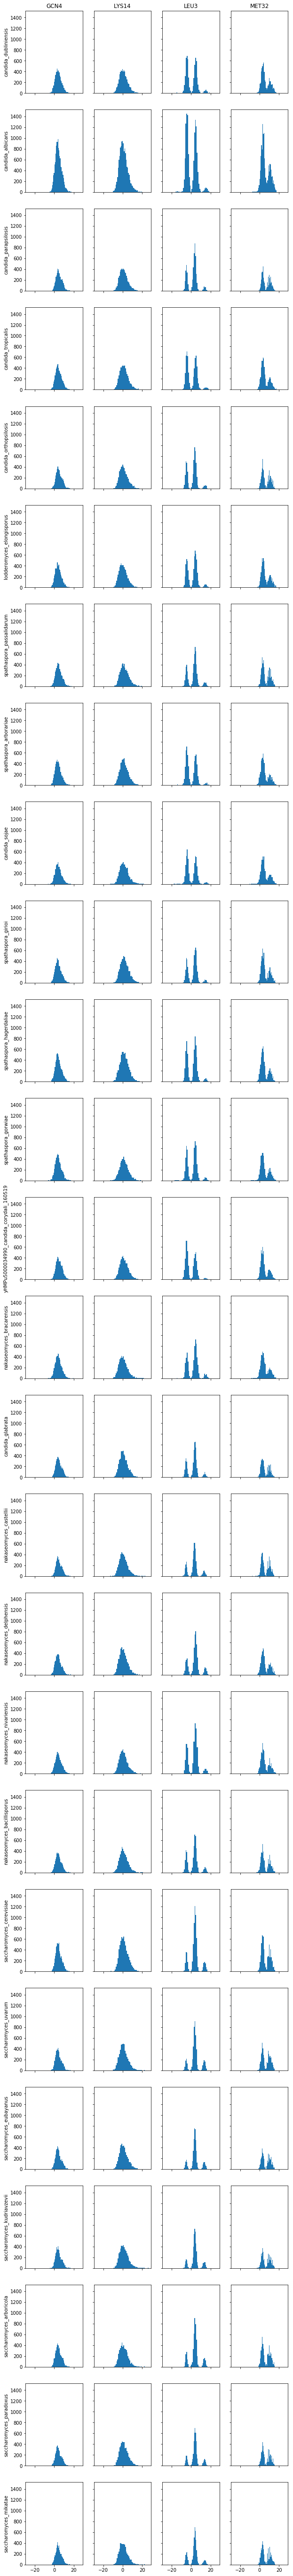

In [17]:
#Show distribution of max scores for each motif

motif_names = ['GCN4', 'LYS14', 'LEU3', 'MET32']
fig, axarr = plt.subplots(len(genome_names),len(motif_names), sharex=True, sharey=True,figsize = (10,100))

all_max_scores[genome_name]

for jj,genome_name in enumerate(genome_names): 
    print(genome_name)
    
    for kk, motif_name in enumerate(motif_names): 
        ax = axarr[jj,kk]
        ax.hist(all_max_scores[genome_name][motif_name]['max_score'].dropna(),bins=40)
        #ax.set_xlabel('Max $Log_{2}$ Odds Score')
        if kk==0: 
            ax.set_ylabel(genome_name)
        if jj==0: 
            ax.set_title(motif_name)

#fig.tight_layout()  

In [18]:
## The number N does not change for each motif it changes with the pathway, so I am collecting redundant data

#Build dataframe with percentile scores for each pathway
pathway_data = {}
for motif_name in motif_names: 
    print(motif_name)
    pathway_data_motif = {}
    for pway in ['lys', 'cys_met_thr','bcaa']: 
        print(pway)
        pathway_data_motif_pway_scores = {}
        pathway_data_motif_pway_N = {}
        for genome_name in genome_names: 
            scores = all_max_scores[genome_name][motif_name]
            
            spec_id = spec_og_id_lookup[genome_name]

            #make gene_id lookup for the species
            gene_lookup_spec_fname = y1000plus_dir + "id_lookups/" + genome_name + '.csv'
            gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')
            y1000_id_gene_id_lookup = dict(gene_lookup_spec['gene_id'])
            
            gene_scores = []
            gene_N = []
            
            for gene in all_pways_combined[pway]:#
                #gene = 'LYS1'
                y1000_id = y1000_id_lookup_common[gene]
                og = goi_og_lookup[y1000_id]
                og_genes = og_genes_lookup[og]

                spec_genes = [og_gene for og_gene in list(og_genes) if og_gene.split('_')[0]==str(spec_id)]
                
                if genome_name == 'saccharomyces_cerevisiae': 
                    spec_y1000_ids = [y1000_id_gene_id_lookup[spec_gene] for spec_gene in spec_genes]
                else: 
                    spec_y1000_ids = [genome_name+'@'+y1000_id_gene_id_lookup[spec_gene] for spec_gene in spec_genes]

                gene_N.append(len(spec_genes))

                if len(spec_y1000_ids)==0:
                    gene_scores.append(np.nan)
                else: 
                    gene_scores.append(max(scores.loc[spec_y1000_ids]['percentile']))

                  
            pathway_data_motif_pway_scores[genome_name]=gene_scores
            pathway_data_motif_pway_N[genome_name]=gene_N
        
        pathway_data_motif_pway_scores_df = pd.DataFrame.from_dict(pathway_data_motif_pway_scores, orient='index', columns = all_pways_combined[pway])
        pathway_data_motif_pway_N_df = pd.DataFrame.from_dict(pathway_data_motif_pway_N, orient='index', columns = all_pways_combined[pway])
        pathway_data_motif_pway = {'scores':pathway_data_motif_pway_scores_df, 'N': pathway_data_motif_pway_N_df}     
        pathway_data_motif[pway] = pathway_data_motif_pway
    
    pathway_data[motif_name]= pathway_data_motif








GCN4
lys
cys_met_thr
bcaa
LYS14
lys
cys_met_thr
bcaa
LEU3
lys
cys_met_thr
bcaa
MET32
lys
cys_met_thr
bcaa


In [25]:
## Write the data to an excel spreadsheet
## Only need to do once

# with pd.ExcelWriter(os.path.normpath(base_dir + 'data/gcn4_liron/20191108_pathway_data.xlsx')) as writer:  # doctest: +SKIP
#     for motif_name in motif_names: 
#         print(motif_name)
#         for pway in ['lys', 'cys_met_thr','bcaa']: 
#             for field in ['N', 'scores']: 
#                 pathway_data[motif_name][pway][field].to_excel(writer, sheet_name= motif_name + '_' + pway + '_' + field)



GCN4
LYS14
LEU3
MET32


lys
GCN4
lys
LYS14
lys
LEU3
lys
MET32
cys_met_thr
GCN4
cys_met_thr
LYS14
cys_met_thr
LEU3
cys_met_thr
MET32
bcaa
GCN4
bcaa
LYS14
bcaa
LEU3
bcaa
MET32


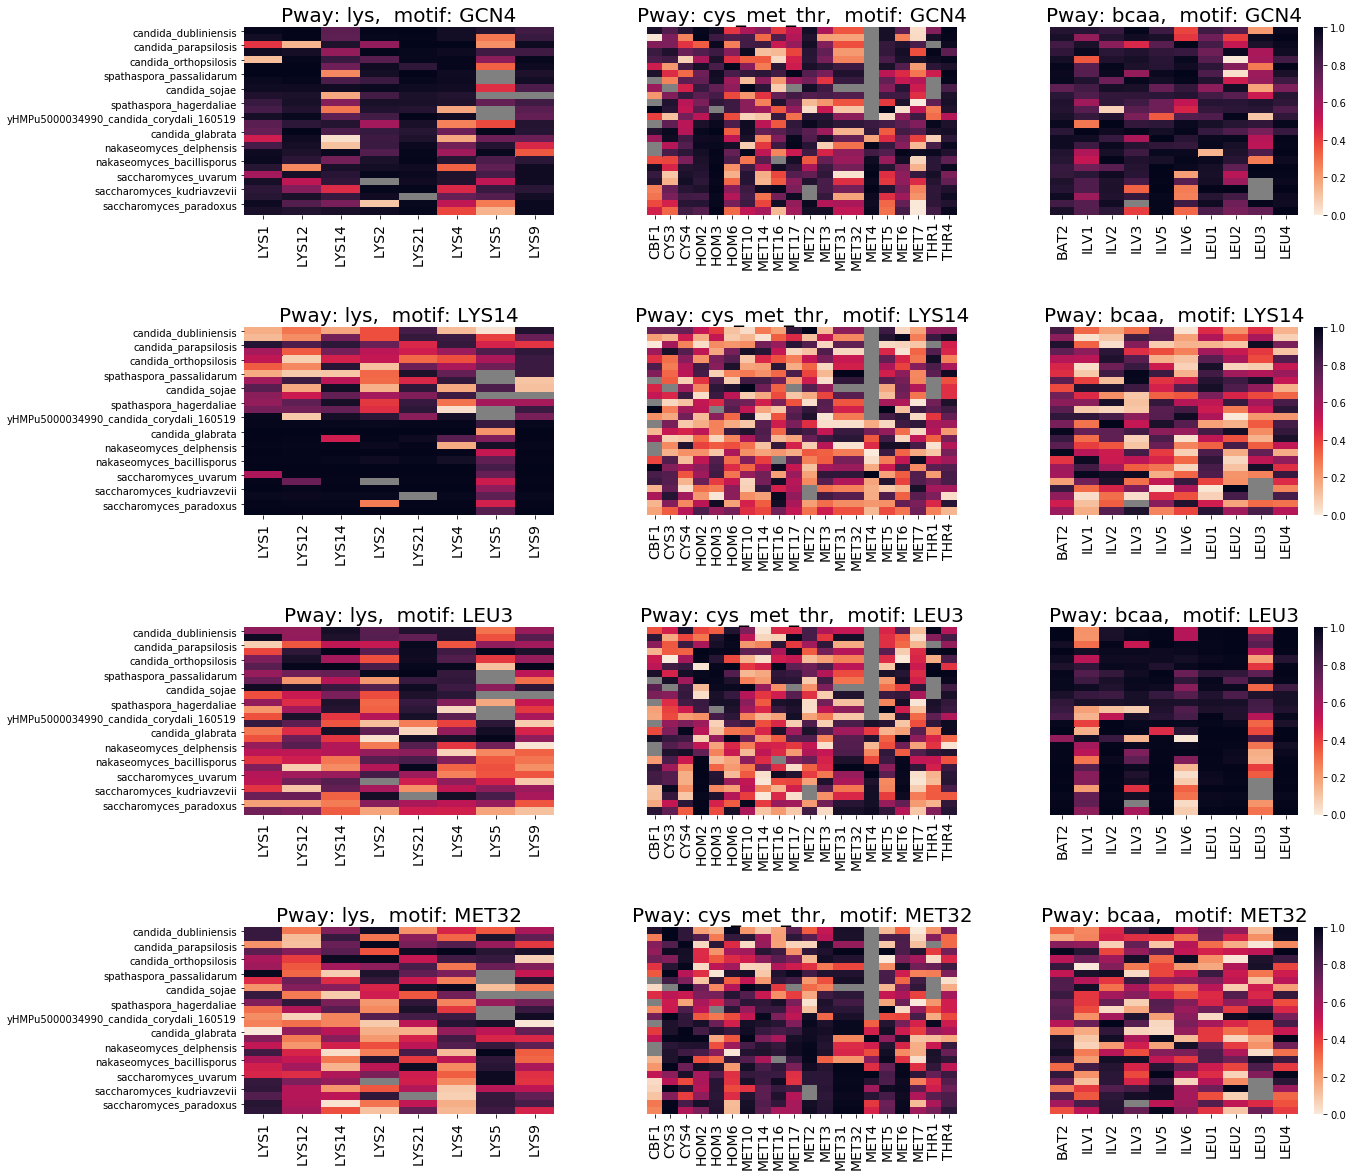

In [181]:
## Select out appropriate columns and visualize heatmap

motif_names = ['GCN4', 'LYS14', 'LEU3', 'MET32']
pways = ['lys', 'cys_met_thr','bcaa']


fig, axarr = plt.subplots(len(motif_names),len(pways), figsize=(20,20))
fig.subplots_adjust(wspace = 0.3, hspace = 0.6)

cmap = sns.cm.rocket_r
cmap.set_under('grey')
cmap.set_over('skyblue')
vmin=0.0
vmax = 1.0


for jj, pway in enumerate(pways):
    for kk, motif_name in enumerate(motif_names):
        print(pway)
        print(motif_name)       
        ax = axarr[kk,jj]
        show_cbar=False
        if jj==(len(pways)-1):
            show_cbar=True
        
        #columns_to_view = [goi_common_name + '_' + motif_name for goi_common_name in goi_groups[goi_group_name]]
        data_matrix_raw = pathway_data[motif_name][pway]['scores'].loc[genome_names,:]
        data_matrix_raw.fillna(-1, inplace=True)
        #data_matrix_raw.replace('NO_ORTH',-1, inplace=True)
        #data_matrix = data_matrix_raw.replace('short_promoters',20)
        #data_matrix = data_matrix.apply(pd.to_numeric)  #not sure why numbers are suddenly strings
        sns.heatmap(data_matrix_raw, ax=ax, cmap = sns.cm.rocket_r, vmin = vmin, vmax =vmax, cbar=show_cbar)
        ax.set_title('Pway: ' + pway + ',  motif: '+ motif_name, fontdict={'size':20})
        if jj != 0:
            ax.set_yticks([])
        #ax.set_xticklabels('')
        ax.set_xticklabels(ax.get_xticklabels(), fontdict = {'size':14}, rotation=90)
        ax.set_ylabel('')
fig.savefig(home_dir + os.path.normpath('scratch/20190923_lys14_gcn4_met31_leu3_percentile.svg'))

lys
cys_met_thr
bcaa


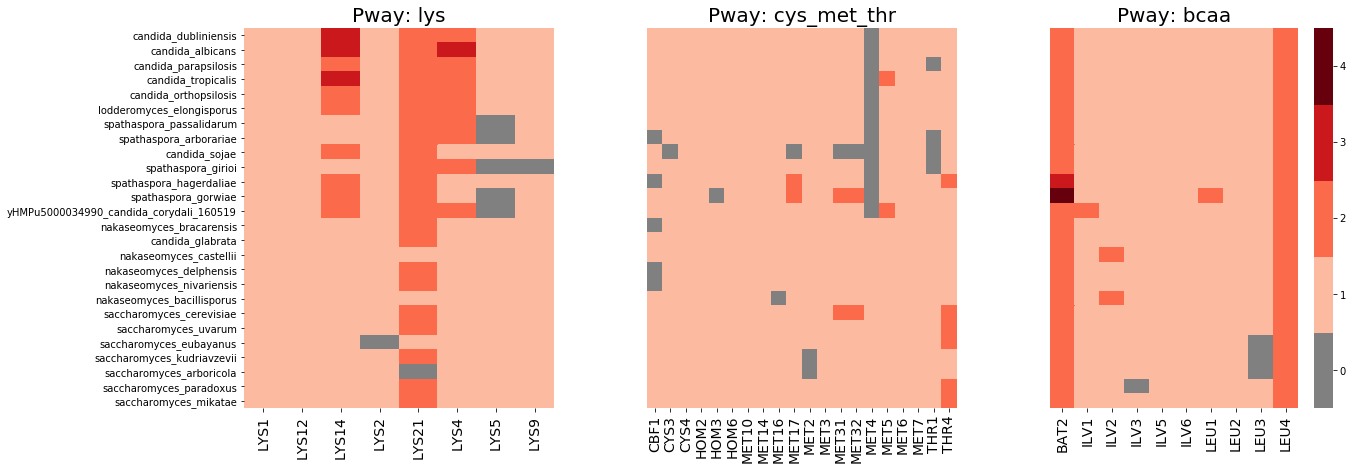

In [182]:
#Visualize number of paralogs
## Select out appropriate columns and visualize heatmap

motif_names = ['GCN4', 'LYS14', 'LEU3', 'MET32']
pways = ['lys', 'cys_met_thr','bcaa']


fig, axarr = plt.subplots(1,len(pways), figsize=(20,7))
fig.subplots_adjust(wspace = 0.3, hspace = 0.6)



vmin = -0.5
vmax = 4.5
cmap = plt.cm.get_cmap('Reds', vmax+0.5)
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

#cmap = sns.cm.rocket_r

# create the new map

cmap_new = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)


motif_name = 'LYS14'
for jj, pway in enumerate(pways):
    print(pway)
    ax = axarr[jj]
    show_cbar=False
    if jj==(len(pways)-1):
        show_cbar=True

    #columns_to_view = [goi_common_name + '_' + motif_name for goi_common_name in goi_groups[goi_group_name]]
    data_matrix_raw = pathway_data[motif_name][pway]['N'].loc[genome_names,:]
    data_matrix_raw.fillna(-1, inplace=True)
    #data_matrix_raw.replace('NO_ORTH',-1, inplace=True)
    #data_matrix = data_matrix_raw.replace('short_promoters',20)
    #data_matrix = data_matrix.apply(pd.to_numeric)  #not sure why numbers are suddenly strings
    sns.heatmap(data_matrix_raw, ax=ax, cmap = cmap_new, vmin = vmin, vmax =vmax, cbar=show_cbar)
    ax.set_title('Pway: ' + pway, fontdict={'size':20})
    if jj != 0:
        ax.set_yticks([])
    #ax.set_xticklabels('')
    ax.set_xticklabels(ax.get_xticklabels(), fontdict = {'size':14}, rotation=90)
    ax.set_ylabel('')
fig.savefig(home_dir + os.path.normpath('scratch/20190923_pway_N.svg'))

In [173]:
pathway_data['GCN4']['bcaa']['scores'].loc[genome_names,:]

,LEU4,BAT2,LEU1,ILV1,LEU2,ILV2,ILV3,LEU3,ILV5,ILV6
candida_dubliniensis,0.969070,0.903849,0.835098,0.900656,0.774416,0.853253,0.984535,0.207094,0.837788,0.387628
candida_albicans,0.995330,0.934949,0.715723,0.630223,0.403188,0.906127,0.953224,0.969568,0.932212,0.421383
candida_parapsilosis,0.974053,0.825000,0.817424,0.933333,0.513826,0.653598,0.457576,0.925947,0.766098,0.999432
candida_tropicalis,0.956653,0.874142,0.719498,0.973389,0.968870,0.888703,0.912301,0.575230,0.868787,0.851883
candida_orthopsilosis,0.822717,0.947237,0.777053,0.351113,0.011320,0.916731,0.938219,0.586531,0.893707,0.980238
lodderomyces_elongisporus,0.995442,0.984808,0.886226,0.771607,0.669142,0.985820,0.924207,0.279541,0.899730,0.954254
spathaspora_passalidarum,0.930286,0.970879,0.798976,0.776032,0.028062,0.969820,0.627780,0.612072,0.973703,0.998059
spathaspora_arborariae,0.841364,0.979475,0.907636,0.912854,0.494173,0.716994,0.984171,0.624978,0.952513,0.987476
candida_sojae,0.682471,0.756640,0.645485,0.821759,0.952390,0.938816,0.930553,0.184733,0.735786,0.865237
spathaspora_girioi,0.895143,0.888163,0.820734,0.794148,0.765780,0.869449,0.873905,0.503639,0.890242,0.903906


## Lys144 TF targets from Christian's paper

In [49]:
#Genes next to all LYS144 peaks from Christian's paper greater than 2.0 Log2 units 
lys144_top = {'C4_07100C_A': 'C4_07100C_A', 
 'ROA1':'C1_01920W_A', 
 'DAL8':'C3_04160W_A', 
 'C5_02920W_A': 'C5_02920W_A',
 'GND1': 'C1_13860C_A',
 'C5_03670C_A': 'C5_03670C_A', 
 'ZCF9': 'C2_00500W_A', 
 'C4_03050C_A':'C4_03050C_A', 
 'CR_09700W_A':'CR_09700W_A', 
 'C6_02950C_A':'C6_02950C_A', 
 'C6_02960W_A':'C6_02960W_A', 
 'AFP99': 'C3_04200W_A', 
 'HNM1': 'C2_01210C_A', 
 'NCP1': 'C4_03180W_A'}

In [50]:
lys144_gois = list(lys144_top.values())

#Make promoter files for various genes of interest
#Load C.alb lookup table: 
calb_lookup_fname = y1000plus_dir + os.path.normpath('id_lookups/candida_albicans.csv')

calb_lookup = pd.read_csv(calb_lookup_fname, index_col=0)
#calb_lookup['SC_common_name'] = y1000plus_tools.io_library.SC_common_name_lookup(scer_lookup.index)

y1000_id_lookup = dict(zip(calb_lookup.loc[lys144_gois].index, calb_lookup.loc[lys144_gois,'y1000_id']))

goi_og_lookup, og_genes_lookup = y1000plus_tools.make_og_genes_lookup(list(y1000_id_lookup.values()), y1000_species_subset)

In [48]:
all_max_scores['saccharomyces_cerevisiae']

{'GCN4':            len  max_score  percentile
 id                                   
 YAL002W    700   8.511666    0.880662
 YAL003W    700  -1.760192    0.007002
 YAL004W    700   6.249276    0.733462
 YAL005C    700  -2.007543    0.004917
 YAL007C    700   4.183173    0.494041
 YAL008W    700   3.903599    0.457092
 YAL009W    700   2.092205    0.211412
 YAL010C    700   1.992625    0.199791
 YAL011W    700   8.780439    0.891389
 YAL012W    700   3.970526    0.465286
 YAL013W    700   4.381186    0.519070
 YAL014C    700  12.639050    0.989869
 YAL015C    700   8.354852    0.872616
 YAL016C-A  700   9.494985    0.925805
 YAL016C-B  700   5.607991    0.675507
 YAL016W    700   3.514400    0.396752
 YAL017W    700   7.210078    0.803337
 YAL018C    700   7.350057    0.813617
 YAL019W    700   1.016695    0.112634
 YAL019W-A  700   6.517220    0.754917
 YAL020C    700   1.408463    0.143027
 YAL021C    700   6.592764    0.759088
 YAL022C    700   4.437284    0.526520
 YAL023C    700  

In [66]:
motif_names = ['GCN4', 'LYS14', 'LEU3', 'MET32']

#Build dataframe with percentile scores for each pathway
lys144_data = {}
for motif_name in motif_names: 
    print(motif_name)
    lys144_data_motif_scores = {}
    lys144_data_motif_N = {}
    for genome_name in genome_names: 
        scores = all_max_scores[genome_name][motif_name]

        spec_id = spec_og_id_lookup[genome_name]

        #make gene_id lookup for the species
        gene_lookup_spec_fname = y1000plus_dir + "id_lookups/" + genome_name + '.csv'
        gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')
        y1000_id_gene_id_lookup = dict(gene_lookup_spec['gene_id'])

        gene_scores = []
        gene_N = []

        for gene_common, gene in lys144_top.items():
            #gene = 'LYS1'
            y1000_id = y1000_id_lookup[gene]
            og = goi_og_lookup[y1000_id]
            og_genes = og_genes_lookup[og]

            spec_genes = [og_gene for og_gene in list(og_genes) if og_gene.split('_')[0]==str(spec_id)]

            if genome_name == 'saccharomyces_cerevisiae': 
                spec_y1000_ids = [y1000_id_gene_id_lookup[spec_gene] for spec_gene in spec_genes]
            else: 
                spec_y1000_ids = [genome_name+'@'+y1000_id_gene_id_lookup[spec_gene] for spec_gene in spec_genes]

            gene_N.append(len(spec_genes))

            if len(spec_y1000_ids)==0:
                gene_scores.append(np.nan)
            else: 
                gene_scores.append(max(scores.loc[spec_y1000_ids]['percentile']))


        lys144_data_motif_scores[genome_name]=gene_scores
        lys144_data_motif_N[genome_name]=gene_N

    lys144_data_motif_scores_df = pd.DataFrame.from_dict(lys144_data_motif_scores, orient='index', columns = lys144_top.keys())
    lys144_data_motif_N_df = pd.DataFrame.from_dict(lys144_data_motif_N, orient='index', columns = lys144_top.keys())
    lys144_data_motif = {'scores':lys144_data_motif_scores_df, 'N': lys144_data_motif_N_df}     
    lys144_data[motif_name]= lys144_data_motif

GCN4
LYS14
LEU3
MET32


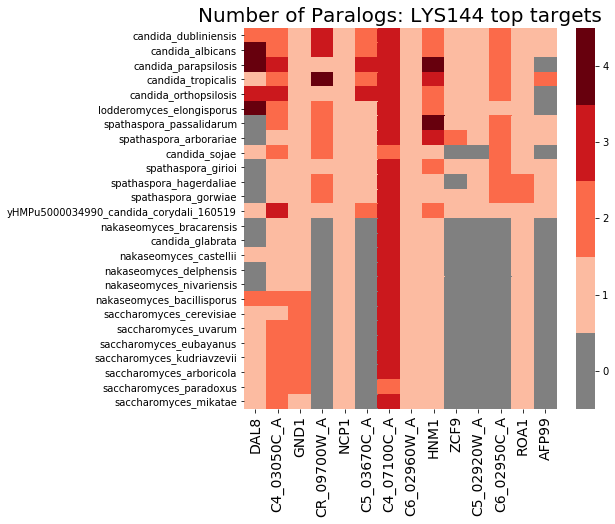

In [82]:
#Visualize number of paralogs
## Select out appropriate columns and visualize heatmap

fig, ax = plt.subplots(1,1, figsize=(7,7))
#fig.subplots_adjust(wspace = 0.3, hspace = 0.6)



vmin = -0.5
vmax = 4.5  #there are a maximum of 4 paralogs
cmap = plt.cm.get_cmap('Reds', vmax+0.5)
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

#cmap = sns.cm.rocket_r

# create the new map

cmap_new = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)


motif_name = 'LYS14'
# show_cbar=False
# if jj==(len(pways)-1):
#     show_cbar=True

#columns_to_view = [goi_common_name + '_' + motif_name for goi_common_name in goi_groups[goi_group_name]]
data_matrix_raw = lys144_data[motif_name]['N'].loc[genome_names,:]
data_matrix_raw.fillna(-1, inplace=True)
#data_matrix_raw.replace('NO_ORTH',-1, inplace=True)
#data_matrix = data_matrix_raw.replace('short_promoters',20)
#data_matrix = data_matrix.apply(pd.to_numeric)  #not sure why numbers are suddenly strings
sns.heatmap(data_matrix_raw, ax=ax, cmap = cmap_new, vmin = vmin, vmax =vmax, cbar=True)
ax.set_title('Number of Paralogs: LYS144 top targets', fontdict={'size':20})
#ax.set_xticklabels('')
ax.set_xticklabels(ax.get_xticklabels(), fontdict = {'size':14}, rotation=90)
ax.set_ylabel('')

fig.savefig(home_dir + os.path.normpath('scratch/20191108_lys144_top_N.svg'))

GCN4
LYS14
LEU3
MET32


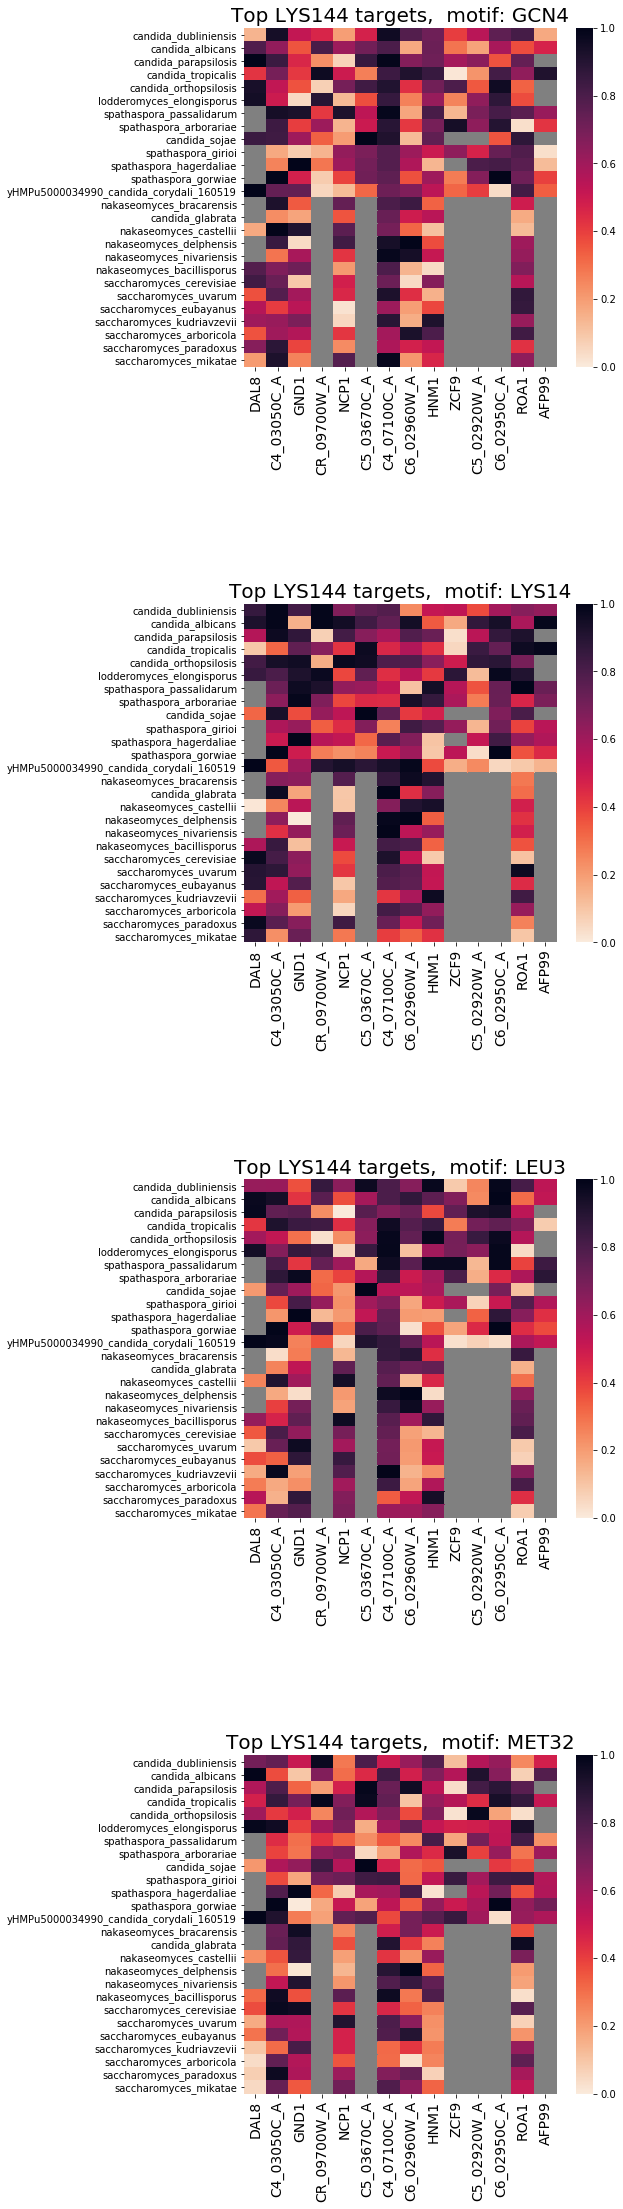

In [81]:
## Select out appropriate columns and visualize heatmap

motif_names = ['GCN4', 'LYS14', 'LEU3', 'MET32']

fig, axarr = plt.subplots(len(motif_names),1, figsize=(7,38))
fig.subplots_adjust(wspace = 0.3, hspace = 0.7)

cmap = sns.cm.rocket_r
cmap.set_under('grey')
cmap.set_over('skyblue')
vmin=0.0
vmax = 1.0


for kk, motif_name in enumerate(motif_names):
    print(motif_name)       
    ax = axarr[kk]
#     show_cbar=False
#     if jj==(len(pways)-1):
    show_cbar=True
    

    #columns_to_view = [goi_common_name + '_' + motif_name for goi_common_name in goi_groups[goi_group_name]]
    data_matrix_raw = lys144_data[motif_name]['scores'].loc[genome_names,:]
    data_matrix_raw.fillna(-1, inplace=True)
    #data_matrix_raw.replace('NO_ORTH',-1, inplace=True)
    #data_matrix = data_matrix_raw.replace('short_promoters',20)
    #data_matrix = data_matrix.apply(pd.to_numeric)  #not sure why numbers are suddenly strings
    sns.heatmap(data_matrix_raw, ax=ax, cmap = sns.cm.rocket_r, vmin = vmin, vmax =vmax, cbar=show_cbar)
    ax.set_title('Top LYS144 targets,  motif: '+ motif_name, fontdict={'size':20})
#     if jj != 0:
#         ax.set_yticks([])
    #ax.set_xticklabels('')
    ax.set_xticklabels(ax.get_xticklabels(), fontdict = {'size':14}, rotation=90)
    ax.set_ylabel('')
fig.savefig(home_dir + os.path.normpath('scratch/20191108_lys144_top_percentile.svg'))

In [84]:
# Write the data to an excel spreadsheet
# Only need to do once

with pd.ExcelWriter(os.path.normpath(base_dir + 'data/gcn4_liron/20191108_lys144_data.xlsx')) as writer:  # doctest: +SKIP
    for motif_name in motif_names: 
        print(motif_name)
        for field in ['N', 'scores']: 
            lys144_data[motif_name][field].to_excel(writer, sheet_name= motif_name + '_' + field)



GCN4
LYS14
LEU3
MET32


## Get top genes in each clade for each motif

## Older code - what is it for?

In [93]:
#make gene_id lookup for the species
gene_lookup_spec_fname = y1000plus_dir + "id_lookups/" + genome_name + '.csv'
gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')
y1000_id_gene_id_lookup = dict(gene_lookup_spec['gene_id'])

In [95]:
y1000_id_gene_id_lookup[list(og_genes)[0]]

'Seq_4420'

In [65]:
a = copy.deepcopy(all_max_scores['saccharomyces_uvarum']['GCN4'])
ecdf = ECDF(a['max_score'])
a['percentile']= ecdf(a['max_score'])
a

,len,max_score,percentile
id,,,
saccharomyces_uvarum@Seq_1,700,7.243496,0.807154
saccharomyces_uvarum@Seq_10,700,7.199612,0.804157
saccharomyces_uvarum@Seq_100,700,3.462850,0.411471
saccharomyces_uvarum@Seq_1000,700,3.215120,0.374500
saccharomyces_uvarum@Seq_1001,700,4.712470,0.583533
saccharomyces_uvarum@Seq_1002,700,6.010866,0.722822
saccharomyces_uvarum@Seq_1003,700,3.259443,0.382294
saccharomyces_uvarum@Seq_1004,700,15.467942,0.994804
saccharomyces_uvarum@Seq_1005,700,2.328688,0.256195


In [ ]:
#Build promhits data for all genes, genes activated by PKA inhibition (S.Cer, K.Lac), DEpka + orthologs (could also do de stress)

L_prom = 700
output_format = 'full'
#motif_dict = {'STRE': 'CCCCT', 'TATA': 'TATA[AT]A[AT][AG]', 'PDS': 'AGGGAT'} 
motif_hit_params = {'GCN4': (1e-3, home_dir + 'github/expression_broad_data/expression_data/motifs/GCN4_jaspar.meme', 'All')
#                     'LYS14':(1e-4, home_dir + 'github/expression_broad_data/expression_data/motifs/Lys14_intergenics_20190415.meme', 'All'),
#                     'LEU3': (1e-3, home_dir + 'github/expression_broad_data/expression_data/motifs/LEU3_jaspar_MA0324.1.meme','All'), 
#                     'ARG81': (1e-3, home_dir + 'github/expression_broad_data/expression_data/motifs/ARG81_jaspar_MA0272.1.meme', 'All'),
#                     'MET32': (1e-3, home_dir + 'github/expression_broad_data/expression_data/motifs/MET32_jaspar_MA0333.1.meme', 'All')
                   }
#sequence_context = 2  

spec_og_id_lookup = dict(zip(y1000_species_subset['species_names_fig2'], y1000_species_subset['spec_og_id']))

#for each species
prom_hits = {}
for spec in specs_fig2: 
    #spec = 'Candida_albicans'
    #    = 'Wickerhamomyces_anomalus'#'Candida_albicans'
    genome_name = fig2_to_orig[spec]
    spec_og_id = spec_og_id_lookup[spec]

    #make gene_id lookup for the species
    gene_lookup_spec_fname = y1000plus_dir + "id_lookups/" + genome_name + '.csv'
    gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')
    y1000_id_gene_id_lookup = dict(gene_lookup_spec['gene_id'])

    #Extract all promoters (files should be saved in advance)
    #load all promoters for the species
    all_promoters_fname = home_dir + os.path.normpath('github/expression_broad_data/expression_data/promoter_phylogeny/promoter_sets/' + genome_name + '/all_promoters.fasta')
    all_promoters = SeqIO.parse(all_promoters_fname, "fasta")

    all_promoters_id_to_L = {}
    for seq in all_promoters:
        all_promoters_id_to_L[seq.id] = len(seq.seq)


    # for seq in prot_seqs: 
    #     if seq.id.split('Seq')[0]== outgroup_orig_genome+'_':


    fname_prefix = genome_name + '_all_' 




    #Make dataframe to store hits
    prom_hits_spec = pd.DataFrame.from_dict(all_promoters_id_to_L, orient='index', columns = ['L_prom'])
    # y1000_id_to_Lprom_df = pd.DataFrame.from_dict(y1000_id_to_Lprom, orient='index', columns = ['Lprom'])
    # goi_hits = goi_hits.merge(y1000_id_to_Lprom_df, how = 'outer', left_index=True, right_index=True)

    #make database with fimo hits for each gene
    for motif_name, (thresh, motif_fname, motif_in_file) in motif_hit_params.items(): 
        fimo_hits = y1000plus_tools.promoter_scan_fimo(all_promoters_fname, fname_prefix, motif_name, motif_fname, thresh, motif_in_file='All')   

        fimo_hits_motif = {}
        #for each gene in the genome, make list of hits and scores

        for (genename, prom_hits_row) in prom_hits_spec.iterrows():
            genename
            prom_Lprom = prom_hits_row['L_prom']



            fimo_hits_subset = fimo_hits[fimo_hits['sequence_name']==genename]
            if len(fimo_hits_subset)>0:     
                #                prom_Lprom = y1000_id_to_Lprom[y1000_id]
                #prom_hits = fimo_hits[fimo_hits['sequence_name']==y1000_id]

                #Location is distance from the start codon
                locs = []
                strands = []
                pvals = []
                seqs = []

                for jj,fimo_hits_row in fimo_hits_subset.iterrows():
                    #Just recording location of the start of the motif
                    strand = fimo_hits_row['strand']

                    if strand == '-':
                        loc = prom_Lprom-fimo_hits_row['stop']
                    elif strand == '+': 
                        loc = prom_Lprom-fimo_hits_row['start']

                    if loc<L_prom: 
                        strands.append(strand)
                        locs.append(loc)
                        seqs.append(fimo_hits_row['matched_sequence'])
                        pvals.append(fimo_hits_row['p-value'])

                #identify best pval and store as single value

                if len(strands)>0:
                    best_ind = np.argmin(pvals)
                    best = np.min(pvals)

                    fimo_hits_motif[genename]=(locs, strands, pvals, seqs, best, best_ind)

        fimo_hits_motif_df = pd.DataFrame.from_dict(fimo_hits_motif, orient='index', columns = [motif_name + '_location', motif_name+ '_strand',motif_name + '_pval', motif_name + '_sequence', motif_name +'_best', motif_name + '_best_ind'])

        prom_hits_spec = prom_hits_spec.merge(fimo_hits_motif_df, how = 'left', left_index =True, right_index = True)

    prom_hits[spec] = prom_hits_spec

In [ ]:
#Cluster by columns

motif_groups = [('met','MET32'),
                ('bcaa','LEU3'),
                ('lys','LYS14'),
                ('arg','LEU3')
               ]

goi_groups_reorder = {}

for goi_group_name, motif_name in motif_groups: 
    
    columns_to_view = [goi_common_name + '_' + motif_name for goi_common_name in goi_groups[goi_group_name]]
    data_matrix_raw = species_data_matrix.loc[ca_cousins_names + sc_cousins_names,columns_to_view]
    #For clustering making no orth and short promoters nan. 
    data_matrix_raw.replace('NO_ORTH',np.nan, inplace=True)
    data_matrix_raw.replace('short_promoters',np.nan, inplace=True)
    data_matrix_raw.fillna(0, inplace=True)
    #data_matrix_raw.replace('NO_ORTH',-1, inplace=True)
    #data_matrix = data_matrix_raw.replace('short_promoters',20)
    data_matrix = data_matrix_raw.apply(pd.to_numeric) 

    # #Performs heirarchical clustering on filtered data.  

    dm = spd.pdist(data_matrix.values.T, metric = io_library.correlation_nan_filt)
    col_cluster = sch.linkage(dm, method='average', optimal_ordering=True)    #might also try 'centroid', 'median', and 'ward'

    col_ind_reorder = sch.leaves_list(col_cluster)

    old_cols = data_matrix.columns.tolist()
    new_cols = [old_cols[ind] for ind in col_ind_reorder]
    new_group_order = [new_col.split('_')[0] for new_col in new_cols]
    goi_groups_reorder[goi_group_name] = new_group_order

goi_groups_reorder

#     data_matrix_reorder = data_matrix.loc[:,new_cols]
#     data_matrix_reorder